# Hierarchical Clustering with Average Linkage
In this lab we'll implement hierarchical clustering with average linkage. We'll be using data that looks like some kind of knowckoff MNIST data.  

In [1]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from sklearn import datasets
from sklearn import manifold, datasets

## Pull Data

In [2]:
digits = datasets.load_digits(n_class=10)
X = digits.data[0:500,:]
y = digits.target[0:500]
n_samples, n_features = X.shape
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)

<Figure size 432x288 with 0 Axes>

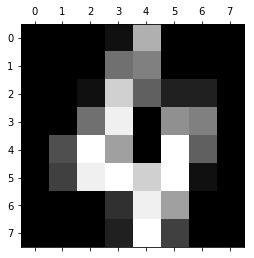

In [3]:
plt.gray() 
plt.matshow(digits.images[4]) 
plt.show() 

## Coding up Hierarchical Clustering

Now we're going to implement hierarchical clustering. I'm following some simple pseudo code from [Wikipedia](https://en.wikipedia.org/wiki/Single-linkage_clustering).

The main algorithm is as follows

1. Begin with the disjoint clustering having height h(0) = 0 and sequence number (algorithm iteration) m = 0.
2. Find the most similar pair of clusters in the current clustering, say pair (r), (s), according to d[(r),(s)] = min d[(i),(j)] where the minimum is over all pairs of clusters in the current clustering.
3. Increment the sequence number: m = m + 1. Merge clusters (r) and (s) into a single cluster to form the next clustering m. Set the height of this clustering to h(m) = d[(r),(s)] 
4. Update the distance matrix, D, by deleting the rows and columns corresponding to clusters (r) and (s) and adding a row and column corresponding to the newly formed cluster. The proximity between the new cluster, denoted (r,s) and old cluster (k) is defined as d[(k), (r,s)] = average d[(k),(r)], d[(k),(s)].
5. If all objects are in one cluster, stop. Else, go to step 2. Alternatively you can also iterate for n-1 steps.

You'll want to familiarize yourself with [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) and [sets](https://docs.python.org/2/library/sets.html). I'll be using euclidean distance for my work and suggest you do as well.

In [4]:
def fuseClusters(i, j, currentClusters):
    """
    Description: Merges the two clusters located at index i and j in currentClusters. This should be
        a rather short chunk of code (~1 line.)
    Input: 
        i,j (int): Indices into currentClusters
        currentClusters list(set()): A list of the current clusters at each step in clustering
    Output:
       clusterSet (set()): The merged clusters.
    """
    assert clusterSetList[i].intersection(clusterSetList[j]) == set(), "clusters with overlapping elements is fishy"
    # Your code here
    clusterSet = clusterSetList[i].union(clusterSetList[j])
    # End your code
    assert len(clusterSet) > 1, "You should not add any clusters of size 1."   
    return(clusterSet)

def calculateClusterDistances(X, clusterSetList, clusterIdx):
    """
    Description: Calculates the distance between each cluster and the cluster at clusterIdx.
        Uses average linking, but you could implement different linkage functions pretty easily.
    Input: 
        X (np matrix): A matrix with observations over rows.
        clusterSetList (list(set())): A list of sets where each set contains the cluster merged at step i.
            From this list you can create many clusters depending on your cut height.
        clusterIdx (int): Cluster wrt calculate the distance to for every other cluster.
    Output:
        clusterDistances (list): A list of distances of the cluster at clusterIdx to all other clusters.
    """
    n = len(clusterSetList)
    clusterDistances = [0]*n# where to store the distance of each cluster to clusterIdx
    clusterIdxSubMat = X[list(clusterSetList[clusterIdx]), :]
    # Calculate the distance between each cluster and the cluster at clusterIdx using average linkage.
    # Your code here
    for idx, clusterSet in enumerate(clusterSetList):
        allDistances = cdist(clusterIdxSubMat, X[list(clusterSet), :], metric = "euclidean")
        clusterDistances[idx] = np.average(allDistances)
    clusterDistances[clusterIdx] = np.Inf
    # End your code
    return(clusterDistances)



def clusterSanityCheck(clusterSetList, n):
    """
    Description: Performs a sanity check to make sure your clusters make sense. Checks that
        each cluster exists only once in clusterSetList, and that the larger clusters occur at the
        end of the list. You can ignore these errors by not using this function, but I think they should
        be helpful.
    Input: 
        clusterSetList (list(set())): A list of sets where each set contains the cluster merged at step i.
            From this list you can create many clusters depending on your cut height.
        n (int): The number of observations in the dataset
    Output:
        Not really important. Will error out if something is weird.
        
    """
    previousClusters = []
    for i in range(n):
        prevSet = set()
        for clusterSet in clusterSetList:
            if i == 0:
                assert clusterSet not in previousClusters, "cluster exists twice in cluster list\n{}".format(clusterSet)
                previousClusters.append(clusterSet)
            if i in clusterSet:
                assert prevSet.issubset(clusterSet), "element {} might occur in multiple sets".format(i)
                prevSet = clusterSet
    return(True)



def hclust(X):
    """
    Description: Performs hierarchical clustering on the data in X. This follows the algorithm above
        pretty closely
    Input: 
        X (np matrix): A matrix with observations over rows.
    Output:
        clusterSetList (list(set())): A list of sets where each set contains the cluster merged at step i.
            From this list you can create many clusters depending on your cut height.
        clusterHeightList (list(float)): A list of floats. Each value is the height that each cluster was 
            merged at.
    """
    n, m = X.shape
    infDiag = np.zeros((n, n), float)# this will come in handy so the algorithm doesn't keep choosing 
    # to merge the same elements over and over because of their distance along the diagonal.
    np.fill_diagonal(infDiag, np.inf)

    
    # we want to hold on to two lists. A list of sets representing the clusters at each iteration
    # and a list of ints representing the height that each cluster was merged at.
    
    singleClusterSetList = [set([x]) for x in range(n)]# the single element clusters
    singleClusterSetList.extend([set()]*(n-1))# a list containing the most recent cluster at each step
    clusterSetList = singleClusterSetList

    singleClusterHeight = [0 for x in range(n)]# corresponds to above.
    singleClusterHeight.extend([0]*(n-1))
    clusterHeightList = singleClusterHeight

    pairWiseDistMat = cdist(X, X, metric = "euclidean") + infDiag
    currentClusters =  [set([x]) for x in range(n)]# single clusters
    # this element is used for this function only and keeps track of the current clusters instead of all
    # clusters at each iteration.

    clusterIndx = 0 + n# +n to get beyond the initial single element clusters
    for i in range(0 + n, n-1 + n):
        # Your code here
        ##STEP 2##
        i_min,j_min = np.unravel_index(pairWiseDistMat.argmin(), pairWiseDistMat.shape)# get the 
        # index of the two closest observations i, j where i!= j
        ##STEP 3##
        height = pairWiseDistMat[i_min,j_min]
        clusterSet = fuseClusters(i_min, j_min, currentClusters)
        ##STEP 4##
        # deleting rows and columns of distance mat corresponding to i_min and j_min clusters
        pairWiseDistMat = np.delete(pairWiseDistMat, [i_min, j_min], axis = 0)
        pairWiseDistMat = np.delete(pairWiseDistMat, [i_min, j_min], axis = 1)
        currentClusters = [clust for idx, clust in enumerate(currentClusters) if idx not in [i_min, j_min]]
        assert clusterSet not in clusterSetList, "about to add a set twice.\n{}".format(clusterSet)
        currentClusters.append(clusterSet)
        clusterSetList[clusterIndx] = clusterSet
        clusterHeightList[clusterIndx] = height
        # update pairwise distance matrix with the pairwise distance for the new cluster
        newPairWiseDistance = calculateClusterDistances(X = X, clusterSetList = currentClusters, clusterIdx = -1)
        pairWiseDistMat = np.pad(pairWiseDistMat, (0,1), 'constant', constant_values=(23))
        pairWiseDistMat[-1,:] = newPairWiseDistance
        pairWiseDistMat[:,-1] = newPairWiseDistance
        clusterIndx += 1
    # End your code
    clusterSanityCheck(clusterSetList, n)

    assert len(clusterHeightList) == len(clusterSetList), "each cluster needs a merge height"
    return(clusterSetList, clusterHeightList)


clusterSetList, clusterHeightList = hclust(X_red)

In [5]:
def clusterAssignments(clusterSetList, clusterHeightList, cutOffheight):
    """
    Description: Determine cluster assignments  for each element using the clusters at created at
        each iteration and a cutoff height.
    Input: 
        clusterSetList (list(set())): A list of sets where each set contains the cluster merged at step i.
            From this list you can create many clusters depending on your cut height.
        clusterHeightList (list(float)): A list of floats. Each value is the height that each cluster was 
            merged at.
        cutOffheight (int): Only consider clusters with a height below this value
    Output:
        maximalClusterSets (list(set)): This should the set of top level clusters which are under the height
            cutoff.
        clusterMapIdxs (list): Maps each observation to it's cluster. Cluster values are arbitrary, but starting
        with the first maximal cluster as cluster number 1 isn't bad.
    """
    maximalClusterSets = []
    n = 0
    # Your code here
    for clusterSetCandidate, clusterHeight in zip(reversed(clusterSetList), reversed(clusterHeightList)):
        if clusterHeight > cutOffheight:
            continue
        notASubset = True
        for clusterToCheck in maximalClusterSets:
            if clusterSetCandidate.issubset(clusterToCheck):
                notASubset = False
        if notASubset:
#             print("appending")
            maximalClusterSets.append(clusterSetCandidate)
            n += len(clusterSetCandidate)
    # End your code
    clusterMapIdxs = [-1]*n
    # Your code here
    for clustNum, clusterSet in enumerate(maximalClusterSets):
        for elem in clusterSet:
            clusterMapIdxs[elem] = clustNum
    # End your code
    return(maximalClusterSets, clusterMapIdxs)

### Choosing the number of clusters
There are many ways to choose the number of clusters, but because we know there should be 10 clusters in our digit dataset we can vary the height cutoff to get as close to 10 as possible. The closer the better as this will help with checking your answers

In [6]:
maximalClusterSets, clusterLabels = clusterAssignments(clusterSetList, clusterHeightList, cutOffheight = 0.0035)
print(len(maximalClusterSets))

In [7]:
# code snagged from https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

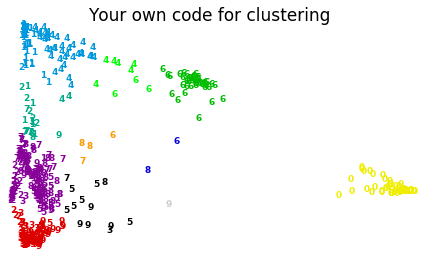

In [8]:


plot_clustering(X_red, clusterLabels, "Your own code for clustering")


plt.show()


Average linkage run time :	0.01s


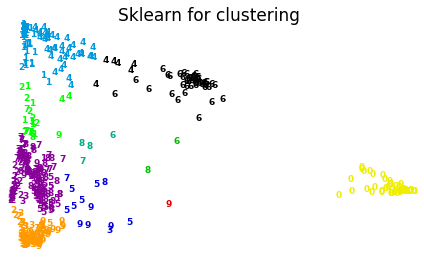

In [12]:
from sklearn.cluster import AgglomerativeClustering
from time import time
clustering = AgglomerativeClustering(linkage = "average", n_clusters=10)
t0 = time()
clustering.fit(X_red)
print("Average linkage run time :\t%.2fs" % (time() - t0))

plot_clustering(X_red, clustering.labels_, "Sklearn for clustering")


plt.show()